In [53]:
%load_ext autoreload

%autoreload 2
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value
import scipy
#module from my personnal github
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)
cluster_z = .4
m = 1e13

In [55]:
def modele_ds(x, m, c): 
    moo.set_mass(m)
    moo.set_concentration(c)
    return moo.eval_excess_surface_density(x, cluster_z)

In [56]:
def dV_dx(x): return 2 * np.pi * x

In [57]:
def integrand_1(x, m, c): return modele_ds(x, m, c) * dV_dx(x)
def integrand_2(x): return x * dV_dx(x)

In [58]:
n_bin = 20
x_edges = np.logspace(np.log10(.1), np.log10(10), n_bin + 1)
x_bin = [[x_edges[i], x_edges[i+1]] for i in range(n_bin)]
x_mean = np.mean(x_bin, axis = 1)

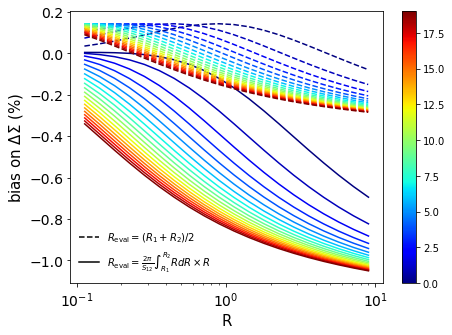

In [59]:
n = 20
nValues = n
nValues = np.arange(n)
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet
c = np.linspace(1, 20, n)
m = np.logspace(14, 14, n)
plt.figure(figsize = (7,5))
for k in range(n):
    r_mean, y_mean, y_true = np.zeros(n_bin),np.zeros(n_bin),np.zeros(n_bin)
    r_mid, y_mid = np.zeros(n_bin),np.zeros(n_bin)
    for i, x_range in enumerate(x_bin):
        norm = scipy.integrate.quad(dV_dx, x_range[0], x_range[1])[0]
        r_mean[i] = scipy.integrate.quad(integrand_2, x_range[0], x_range[1])[0]/norm
        r_mid[i] = np.mean(x_range, axis =0)
        y_mid[i] = modele_ds(r_mid[i], m[k], c[k])
        y_mean[i] = modele_ds(r_mean[i], m[k], c[k])
        y_true[i] = scipy.integrate.quad(integrand_1, x_range[0], x_range[1], args = (m[k], c[k]))[0]/norm
    err_mean=100*(y_mean/y_true-1)
    err_mid=100*(y_mid/y_true-1)
    plt.plot(r_mean, err_mean, '-', linewidth = 1.5, color=colormap(normalize(k)))
    plt.plot(r_mid, err_mid, '--', linewidth = 1.5, color=colormap(normalize(k)))
    
plt.plot([],[], '--k', label= r'$R_{\rm eval} = (R_1 + R_2)/2$')
plt.plot([],[], '-k', label= r'$R_{\rm eval} = \frac{2\pi}{S_{12}} \int_{R_1}^{R_2} R dR \times R $')
plt.xscale('log')
plt.legend(frameon = False)
plt.xlabel('R', fontsize = 15)
plt.ylabel('bias on $\Delta\Sigma$ (%)', fontsize = 15)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple)
plt.tick_params(axis='both', which = 'major', labelsize= 14)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/effect_of_binning.png', bbox_inches='tight', dpi=300)